# SQL


### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [1]:
# Подключаемся к pandas и объявляем параметры подключения 
import pandahouse as ph
import matplotlib.pyplot as plt


connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [2]:
# посмотрим на структуру данных default.peas, поменяем формат данных timest
query = '''
SELECT 
    st_id,
    toDateTime(timest) as datetime,
    correct,
    subject
FROM default.peas
LIMIT 10
'''
ph.read_clickhouse(query=query, connection=connection)

,st_id,datetime,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability
5,100379,2021-10-30 18:02:37,1,Theory of probability
6,100379,2021-10-30 18:17:25,1,Vizualization
7,100379,2021-10-30 18:32:26,0,Theory of probability
8,100379,2021-10-30 19:19:33,1,Vizualization
9,100379,2021-10-30 19:28:03,1,Theory of probability


In [3]:
# проверим, за какой период приведены данные в таблице (увидим, что за 30-31 октября)

query = '''
SELECT
    date(min(timest)) date_min,
    date(max(timest)) date_max
FROM default.peas
'''
ph.read_clickhouse(query=query, connection=connection)

,date_min,date_max
0,2021-10-30,2021-10-31


Напишем запрос, который даст информацию о количестве очень усердных студентов

In [4]:
query = """
SELECT COUNT(*) AS "Количество очень усердных студентов"
FROM (
    SELECT 
        st_id,
        toStartOfMonth(timest) AS start_of_month
    FROM default.peas
    WHERE correct = true
    GROUP BY st_id, start_of_month
    HAVING COUNT(*) >= 20
) AS q1
"""
df = ph.read_clickhouse(query, connection=connection)
print(df)

   Количество очень усердных студентов
0                                  136


### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU;
ARPAU;
CR в покупку; 
СR активного пользователя в покупку; 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [5]:
# посмотрим на структуру данных default.studs
query = '''
SELECT *
FROM default.studs
LIMIT 10
'''
ph.read_clickhouse(query=query, connection=connection)

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot
5,106010,pilot
6,106028,pilot
7,106464,pilot
8,106816,control
9,107250,control


In [6]:
# посмотрим на структуру данных default.final_project_check, поменяем формат sale_time
query = '''
SELECT 
    st_id,
    toDateTime(sale_time) as sale_datetime,
    money,
    subject
FROM default.final_project_check
LIMIT 10
'''
ph.read_clickhouse(query=query, connection=connection)

,st_id,sale_datetime,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math
5,114606,2021-10-31 02:26:19,75000,Statistics
6,147316,2021-10-31 11:12:27,65000,Vizualization
7,149640,2021-10-30 19:53:19,65000,Vizualization
8,230858,2021-10-31 08:14:34,85000,Math
9,269738,2021-10-30 21:33:24,70000,Theory of probability


In [7]:
query = """

SELECT
    test_grp,
    SUM(money) as revenue, 
    COUNT(DISTINCT a.st_id) as all_users, 
    COUNT(DISTINCT CASE WHEN money > 0 THEN a.st_id END) as paying_users, 
    COUNT(DISTINCT CASE WHEN money > 0 and correct_sum > 10 THEN a.st_id END) as active_paying_users,
    SUM(money) / COUNT(DISTINCT a.st_id) AS ARPU,
    SUM(CASE WHEN correct_sum > 10 THEN money ELSE 0 END) / COUNT(DISTINCT CASE WHEN correct_sum > 10 THEN a.st_id END) AS ARPAU,
    COUNT(DISTINCT CASE WHEN money > 0 THEN a.st_id END) / COUNT(DISTINCT a.st_id) * 100 AS CR,
    COUNT(DISTINCT CASE WHEN money > 0 and correct_sum > 10 THEN a.st_id END) / COUNT(DISTINCT CASE WHEN correct_sum > 10 THEN a.st_id END) * 100 AS CR_AU,
    COUNT(DISTINCT CASE WHEN money > 0 and math_correct_sum >= 2 and subject = 'Math' THEN a.st_id END) / COUNT(DISTINCT CASE WHEN math_correct_sum >= 2 THEN a.st_id END) * 100 AS CR_math_purchase
FROM default.studs AS a
LEFT JOIN default.final_project_check AS b ON a.st_id = b.st_id
LEFT JOIN (
           SELECT
               st_id,
               SUM(correct) AS correct_sum,
               SUM(CASE WHEN subject = 'Math' THEN correct ELSE 0 END) AS math_correct_sum
           FROM default.peas
           GROUP BY st_id
          ) AS c ON a.st_id = c.st_id
GROUP BY test_grp


"""

df_2 = ph.read_clickhouse(query, connection=connection)


In [8]:
df_2

,test_grp,revenue,all_users,paying_users,active_paying_users,ARPU,ARPAU,CR,CR_AU,CR_math_purchase
0,control,1385000,305,15,14,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,3395000,295,32,25,11508.474576,29739.583333,10.847458,26.041667,9.523810


Визуализируем воронку продаж по тестовым группам

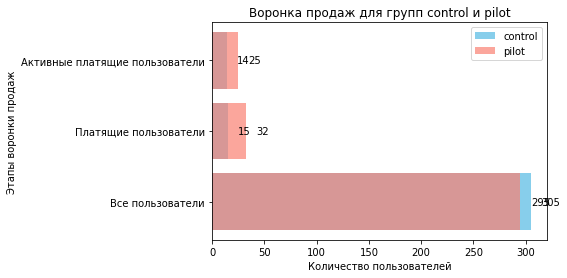

In [9]:

# Данные для воронки продаж для группы "control"
control_all_users = df_2[df_2['test_grp'] == 'control']['all_users'].values[0]
control_paying_users = df_2[df_2['test_grp'] == 'control']['paying_users'].values[0]
control_active_paying_users = df_2[df_2['test_grp'] == 'control']['active_paying_users'].values[0]

control_users = [control_all_users, control_paying_users, control_active_paying_users]

# Данные для воронки продаж для группы "pilot"
pilot_all_users = df_2[df_2['test_grp'] == 'pilot']['all_users'].values[0]
pilot_paying_users = df_2[df_2['test_grp'] == 'pilot']['paying_users'].values[0]
pilot_active_paying_users = df_2[df_2['test_grp'] == 'pilot']['active_paying_users'].values[0]

pilot_users = [pilot_all_users, pilot_paying_users, pilot_active_paying_users]

# Создание воронки продаж для группы "control" и "pilot"
fig, ax = plt.subplots()
labels = ['Все пользователи', 'Платящие пользователи', 'Активные платящие пользователи']
ax.barh(labels, control_users, color='skyblue', label='control')
ax.barh(labels, pilot_users, color='salmon', label='pilot', alpha=0.7)

# Добавление текста с количеством пользователей на каждом этапе для группы "control"
for i, v in enumerate(control_users):
    ax.text(v + 10, i, str(v), color='black', va='center')

# Добавление текста с количеством пользователей на каждом этапе для группы "pilot"
for i, v in enumerate(pilot_users):
    ax.text(v + 10, i, str(v), color='black', va='center')

# Настройка графика

plt.xlabel('Количество пользователей')
plt.ylabel('Этапы воронки продаж')
plt.title('Воронка продаж для групп control и pilot')
plt.legend()

# Отображение графика
plt.show()
